### Edgar Moises Hernandez-Gonzalez
#### 25/03/20-26/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 54.86%
##### Kappa = 0.3981

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM, GRU, ConvLSTM2D,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#unir 22 canales y resize
def unir_espectrogramas_vertical_resize(data):
  dim = (224, 224) #ancho, alto
  fs = 250
  datos = np.zeros((288,224,224))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [ ]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 224, 224)
(288, 224, 224)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

104.01148692841628
97.16353202276794
0.000332680156177237
0.00024957552372513784


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.81258976
0.75909007
2.5990637e-06
1.9498088e-06


In [ ]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 224, 224, 1)
(288, 1, 224, 224, 1)


In [ ]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Train on 288 samples, validate on 288 samples
Epoch 1/200
288/288 - 7s - loss: 1.3829 - acc: 0.2361 - val_loss: 1.3724 - val_acc: 0.2569
Epoch 2/200
288/288 - 5s - loss: 1.3649 - acc: 0.2778 - val_loss: 1.3582 - val_acc: 0.2569
Epoch 3/200
288/288 - 5s - loss: 1.3433 - acc: 0.3368 - val_loss: 1.3418 - val_acc: 0.4062
Epoch 4/200
288/288 - 5s - loss: 1.3177 - acc: 0.4028 - val_loss: 1.3256 - val_acc: 0.3819
Epoch 5/200
288/288 - 5s - loss: 1.2887 - acc: 0.3854 - val_loss: 1.3115 - val_acc: 0.3507
Epoch 6/200
288/288 - 5s - loss: 1.2601 - acc: 0.4340 - val_loss: 1.2875 - val_acc: 0.4062
Epoch 7/200
288/288 - 5s - loss: 1.2291 - acc: 0.4826 - val_loss: 1.2703 - val_acc: 0.4201
Epoch 8/200
288/288 - 5s - loss: 1.2086 - acc: 0.5104 - val_loss: 1.2629 - val_acc: 0.3646
Epoch 9/200
288/288 - 5s - loss: 1.1759 - acc: 0.4931 - val_loss: 1.2385 - val_acc: 0.4062
Epoch 10/200
288/288 - 5s - loss: 1.1499 - acc: 0.5486 - val_loss: 1.2322 - val_acc: 0.3715
Epoch 11/200
288/288 - 5s - lo

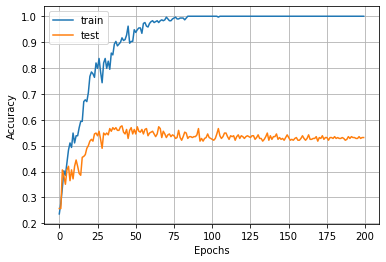

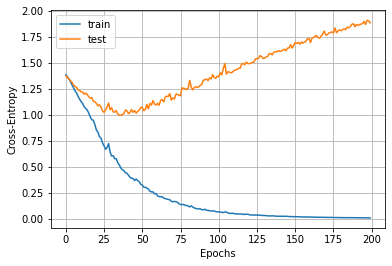

Iteration: 2
Train on 288 samples, validate on 288 samples
Epoch 1/200
288/288 - 7s - loss: 1.3829 - acc: 0.2431 - val_loss: 1.3686 - val_acc: 0.2500
Epoch 2/200
288/288 - 5s - loss: 1.3610 - acc: 0.2569 - val_loss: 1.3536 - val_acc: 0.3160
Epoch 3/200
288/288 - 5s - loss: 1.3374 - acc: 0.3576 - val_loss: 1.3229 - val_acc: 0.4722
Epoch 4/200
288/288 - 5s - loss: 1.3023 - acc: 0.3750 - val_loss: 1.2926 - val_acc: 0.3785
Epoch 5/200
288/288 - 5s - loss: 1.2670 - acc: 0.4653 - val_loss: 1.2521 - val_acc: 0.4444
Epoch 6/200
288/288 - 5s - loss: 1.2248 - acc: 0.4653 - val_loss: 1.2100 - val_acc: 0.4826
Epoch 7/200
288/288 - 5s - loss: 1.1861 - acc: 0.5729 - val_loss: 1.1807 - val_acc: 0.4306
Epoch 8/200
288/288 - 5s - loss: 1.1668 - acc: 0.4757 - val_loss: 1.1637 - val_acc: 0.4688
Epoch 9/200
288/288 - 5s - loss: 1.1139 - acc: 0.5972 - val_loss: 1.1256 - val_acc: 0.4861
Epoch 10/200
288/288 - 5s - loss: 1.0788 - acc: 0.6354 - val_loss: 1.1016 - val_acc: 0.4965
Epoch 11/200
288/288 - 5s - lo

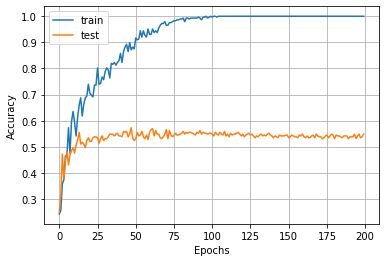

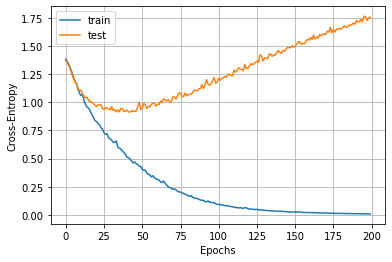


Resultados:
loss: [1.8814074728224013, 1.7550435066223145]
accuracy: [0.53125, 0.5486111]
kappa: [0.375, 0.39814814814814814]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)

  model = Conv_LSTM_2D()

  history = model.fit(x_train, y_train, epochs=200, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_19 (ConvLSTM2D) (None, 224, 224, 64)      150016    
_________________________________________________________________
dropout_21 (Dropout)         (None, 224, 224, 64)      0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 3211264)           0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                51380240  
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 68        
Total params: 51,530,324
Trainable params: 51,530,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5399
std: (+/- 0.0087)
Mean Kappa: 0.3866
std: (+/- 0.0116)
Max Accuracy: 0.5486
Max Kappa: 0.3981
